## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam, SGD
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
33880,00008875_028.png,No Finding,28,8875,65,F,AP,2500,2048,0.168,0.168,NaN,/data/images_004/images/00008875_028.png
44129,00011378_003.png,No Finding,3,11378,57,M,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00011378_003.png
13560,00003523_026.png,Effusion,26,3523,23,F,AP,2500,2048,0.168,0.168,NaN,/data/images_002/images/00003523_026.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

list_labels = [str(x).split('|') for x in all_xray_df['Finding Labels']]
labels = list(np.unique([subitem for item in list_labels for subitem in item]))

for i in labels:
    all_xray_df[i] = [1 if x.find(i)>=0 else 0 for x in all_xray_df['Finding Labels']]
    
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
92415,00023075_031.png,No Finding,31,23075,31,M,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0
26196,00006875_015.png,No Finding,15,6875,54,F,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
93124,00023271_016.png,Infiltration|Pneumonia,16,23271,40,F,AP,3056,2544,0.139,...,0,0,0,1,0,0,0,0,1,0
14413,00003739_001.png,No Finding,1,3739,51,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
3844,00001052_004.png,No Finding,4,1052,47,M,PA,2804,2828,0.143,...,0,0,0,0,0,1,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].replace(1,'pneumonia').replace(0,'non-pneumonia')
all_xray_df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,non-pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,non-pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,non-pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,non-pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,1,0,0,0,0,0,0,0,non-pneumonia


## Create your training and testing data:

In [5]:
def create_splits(dataset):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    ## we apply train_test_split to divide our data into train and validation with a proportion of 80% 
    ## for training and 20% validation
    
    train_data, val_data = train_test_split(dataset,
                                            test_size = 0.2,
                                            stratify = dataset.pneumonia_class)
    
    ## we have to get the same number of non-pneumonia class as pneumonia to train our model
    
    train_no_pneum = train_data[train_data.Pneumonia==0].sample(len(train_data[train_data.Pneumonia==1]))
    train_df = pd.concat([train_no_pneum, train_data[train_data.Pneumonia==1]])
    print('Proportion of pneumonia in our training set: {}%'.format((np.sum(train_df.Pneumonia, axis = 0)/len(train_df))*100))
    
    ## we want 80% of non-pneumonia in our validation and 20% of pneumonia
    
    val_data_no_pneum = val_data[val_data.Pneumonia==0].sample(4*len(val_data[val_data.Pneumonia==1]))
    val_df = pd.concat([val_data_no_pneum, val_data[val_data.Pneumonia==1]])
    print('Proportion of pneumonia in our validation set: {}%'.format((len(val_df[val_df['Pneumonia']==1])/len(val_df))*100))
    
    return train_df, val_df

In [6]:
train_data, val_df = create_splits(all_xray_df)

Proportion of pneumonia in our training set: 50.0%
Proportion of pneumonia in our validation set: 20.0%


In [7]:
paths = train_data.path.values
mean_train = list()
std_train = list()
for i in range(len(paths)):
    arr_img = plt.imread(paths[i])
    mean_train.append(np.mean(arr_img))
    std_train.append(np.std(arr_img))
    
total_mean_train = np.mean(mean_train)
total_std_train = np.mean(std_train)
print('Mean train: {:.2f}'.format(total_mean_train))
print('Std train: {:.2f}'.format(total_std_train))

Mean train: 0.49
Std train: 0.23


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    ## Images are rescaled to normalize them and have values from 0 to 1 and avoid large results
    
    my_idg = ImageDataGenerator(rescale = False,
                            horizontal_flip = True,
                            vertical_flip = False,
                            height_shift_range = 0.25,
                            width_shift_range = 0.15,
                            rotation_range = 15,
                            shear_range = 0.15,
                            zoom_range = 0.2,
                            preprocessing_function = preprocess_input)
    
    # normalization of the training data with mean and std to improve the performance of the CNN
    
    return my_idg


def make_train_gen(train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                                 directory=None, 
                                                 x_col = 'path',
                                                 y_col = 'pneumonia_class',
                                                 class_mode = 'binary',
                                                 target_size = (224, 224), 
                                                 batch_size = 32)

    return train_gen


def make_val_gen(val_data):
    
    ## rescale of the validation data and normalization of the images with the mean and std
    my_val_idg = ImageDataGenerator(rescale = False,
                                   preprocessing_function = preprocess_input)
    

    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224,224), 
                                             batch_size = 128)
    
    return val_gen

In [9]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_df)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


In [10]:
## Apply the augmentation to our data to have our training set

my_train_idg = my_image_augmentation()
train_gen = make_train_gen(train_data)

Found 2290 validated image filenames belonging to 2 classes.


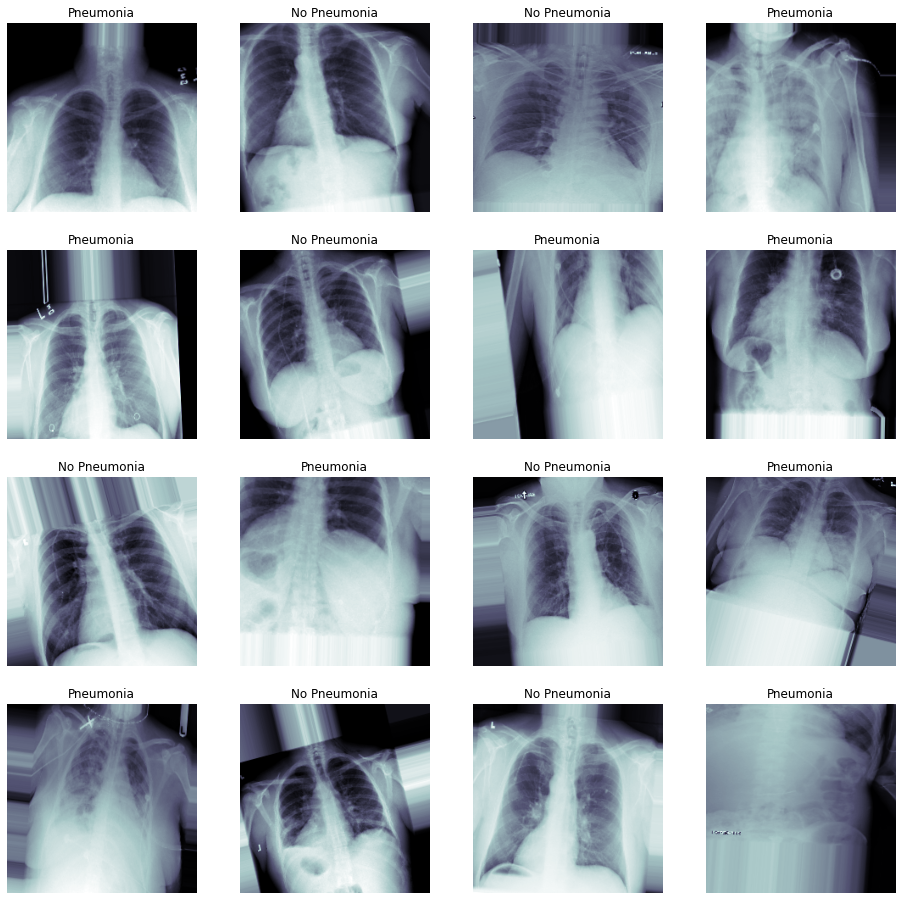

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    
    ## Use the last layer for the output of the CNN
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    ## Train only the last convolutional layer, which will be the one for our specific model
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
        
    
    return vgg_model


In [13]:
model = load_pretrained_model()

## See which layers of the model are trainable, check that only the last convolutional layer
## is trainable

for layer in model.layers:
    print(layer.name, layer.trainable)

553467904/553467096 [==============================] - 6s 0us/step
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [14]:
def build_my_model(vgg_model):
    
    my_model = Sequential()
    
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    my_model.add(vgg_model) # we add the layers from our vgg_model
    
    my_model.add(Flatten()) #we have to flatten our model since it comes from a convolutional layer
    my_model.add(Dropout(0.3))
    
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.4)) # to avoid overfitting
    
    my_model.add(Dense(128, activation='relu'))
    my_model.add(Dropout(0.4)) # to avoid overfitting
    
    my_model.add(Dense(1, activation='sigmoid')) # to get a value between 0 and 1
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [15]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting


weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

## the training will stop when after 10 epochs the validation loss does not decrease

callbacks_list = [checkpoint, early]

### Start training! 

In [16]:
## train your model

my_vgg_model = load_pretrained_model()
my_model = build_my_model(my_vgg_model)
my_model.compile(optimizer = SGD(lr=3e-4), loss='binary_crossentropy', metrics=['binary_accuracy'])
# it has been seen that SGD has better performance than Adam

history = my_model.fit_generator(train_gen, 
                              validation_data = val_gen, 
                              epochs = 50, 
                              callbacks = callbacks_list)

Epoch 1/50
72/72 [==============================] - 92s 1s/step - loss: 3.2822 - binary_accuracy: 0.4978 - val_loss: 1.5687 - val_binary_accuracy: 0.4056

Epoch 00001: val_loss improved from inf to 1.56867, saving model to xray_class_my_model.best.hdf5
Epoch 2/50
72/72 [==============================] - 69s 962ms/step - loss: 2.0156 - binary_accuracy: 0.5354 - val_loss: 0.9094 - val_binary_accuracy: 0.4273

Epoch 00002: val_loss improved from 1.56867 to 0.90938, saving model to xray_class_my_model.best.hdf5
Epoch 3/50
72/72 [==============================] - 71s 980ms/step - loss: 1.6880 - binary_accuracy: 0.5131 - val_loss: 0.7863 - val_binary_accuracy: 0.5322

Epoch 00003: val_loss improved from 0.90938 to 0.78626, saving model to xray_class_my_model.best.hdf5
Epoch 4/50
72/72 [==============================] - 70s 972ms/step - loss: 1.4140 - binary_accuracy: 0.5428 - val_loss: 1.0244 - val_binary_accuracy: 0.4713

Epoch 00004: val_loss did not improve from 0.78626
Epoch 5/50
72/72 [

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [24]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 100, verbose = True)

128/128 [==============================] - 1s 10ms/step


In [25]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    plt.style.use('ggplot')
    fpr, tpr, thres = roc_curve(t_y, p_y, pos_label=1)
    sc = roc_auc_score(t_y, p_y)
    
    plt.plot(fpr, tpr, label='AUC score: {:.2f}'.format(sc))
    plt.xlabel('False positive'), plt.ylabel('True positive')
    plt.legend()
    plt.show()

## what other performance statistics do you want to include here besides AUC? 


# def precision-recall curve is useful to know which threshold we select
def plot_precision_recall(t_y, p_y):
    
    prec, recall, thres = precision_recall_curve(t_y, p_y, pos_label=1)
    fsc = average_precision_score(t_y, p_y)
    
    plt.plot(recall, prec, label='AP Score: {:.2f}'.format(fsc))
    plt.ylabel('Precision'), plt.xlabel('Recall')
    plt.legend()
    plt.show()
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    
    plt.plot(history.history['loss'], label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.plot(history.history['binary_accuracy'], label = 'train_accuracy')
    plt.plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    
def plot_loss_val(history):
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax[0].plot(history.history['loss'], label = 'train_loss')
    ax[0].plot(history.history['val_loss'], label = 'val_loss')
    ax[0].set_title('Loss')
    ax[0].set(xlabel='Epochs')
    ax[0].legend()
    
    ax[1].plot(history.history['binary_accuracy'], label = 'train_accuracy')
    ax[1].plot(history.history['val_binary_accuracy'], label = 'val_accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set(xlabel='Epochs')
    ax[1].legend()
    plt.show()
    
def plot_f1_thres(t_y, p_y):
    prec, recall, thres = precision_recall_curve(t_y, p_y, pos_label=1)
    f1_score = 2*prec*recall/(prec+recall)
    plt.plot(thres, f1_score[:len(thres)], label='f1-score')
    plt.plot(thres, prec[1:], label='precision')
    plt.plot(thres, recall[1:], label='recall')
    plt.xlabel('Threshold'), plt.legend()
    plt.show()

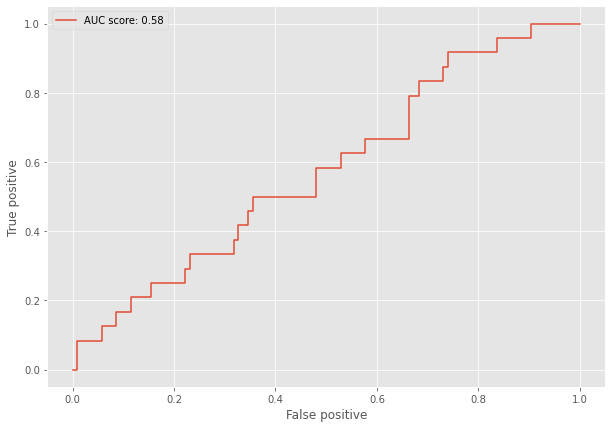

In [31]:
## plot figures
plt.figure(figsize=(10,7))
plot_auc(valY, pred_X)

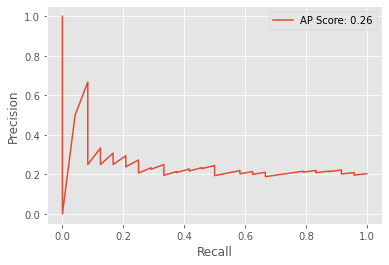

In [27]:
plot_precision_recall(valY, pred_Y)

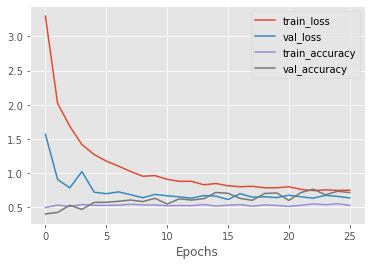

In [28]:
plot_history(history)

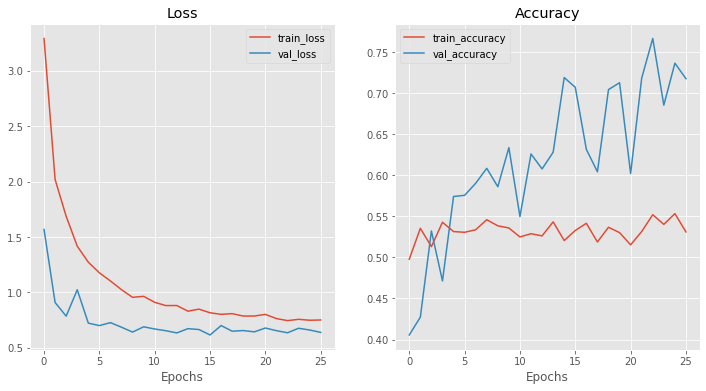

In [29]:
plot_loss_val(history)

## Results

As can be seen in the plot, at 5 epochs we get good results with a validation loss of less than 0.8 and after the 5th epoch, the validation loss maintains while the training one decreases, despite there is no overfitting because the validation accuracy keeps increasing, the response has stabilized.

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


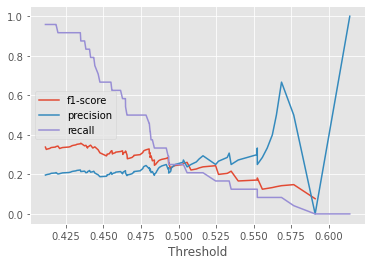

In [32]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

## f1-score will be chosen to optimize the precision in our model
plot_f1_thres(valY, pred_Y)

In [35]:
prec, recall, thres = precision_recall_curve(valY, pred_Y, pos_label=1)
f1_score = 2*prec*recall/(prec+recall)
max_f1 = np.argmax(f1_score[:-5]) #to take other values that make F1 go to infinity
print('The chosen threshold is: {:.2f}'.format(thres[max_f1]))

The chosen threshold is: 0.43


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [42]:
from sklearn.metrics import confusion_matrix
pred2 = np.where(pred_Y>0.43, 1, 0)
confusion_matrix(valY, pred2)

array([[24, 80],
       [ 2, 22]])

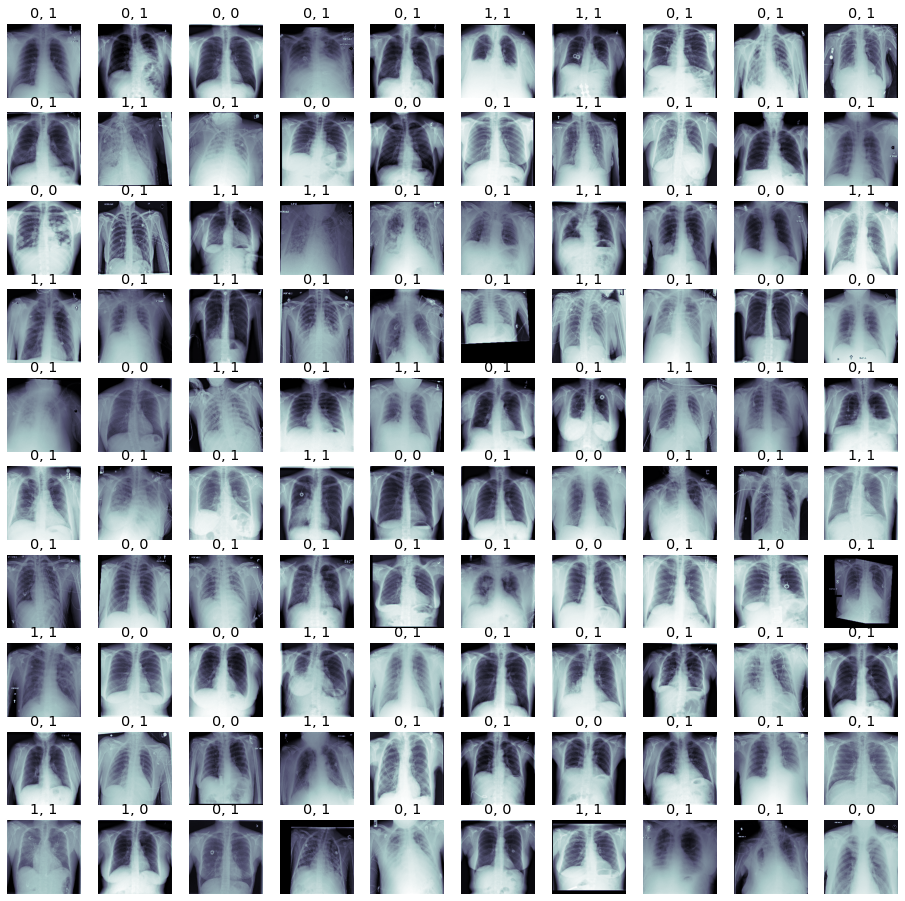

In [43]:
## Let's look at some examples of true vs. predicted with our best model: 

## we select the threshold when the f-score it's maximum so the relation between precision and recall is also maximum
## which is at 0.43

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.43:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.43: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [44]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

In [45]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

# Analysis of the datasets

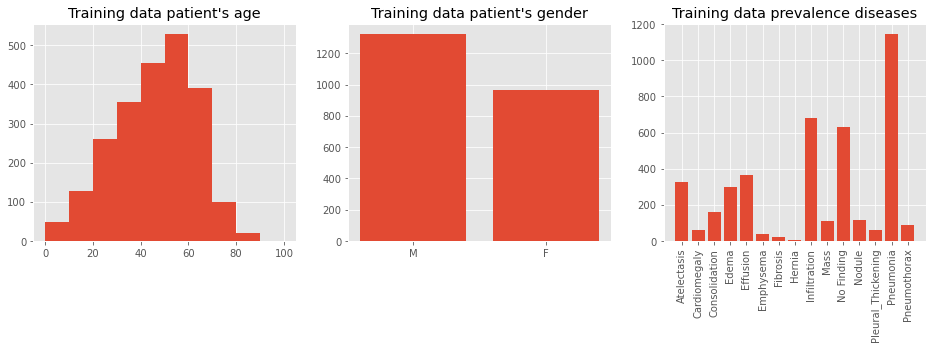

In [46]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].hist(train_data['Patient Age'], range=(0,100))
ax[0].set_title("Training data patient's age")
ax[1].bar(['M','F'], [np.sum(train_data['Patient Gender']=='M'), np.sum(train_data['Patient Gender']=='F')])
ax[1].set_title("Training data patient's gender")
ax[2].bar(labels, [np.sum(train_data[dis]) for dis in labels])
ax[2].set_title("Training data prevalence diseases")
ax[2].set_xticklabels(labels, rotation=90)
plt.show()

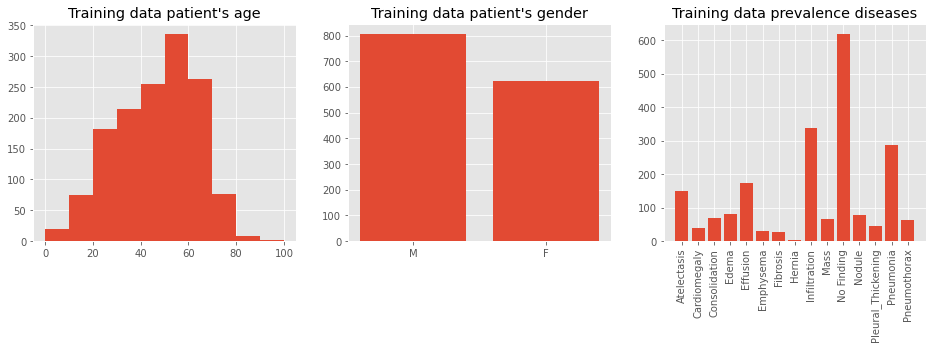

In [47]:
# same with validation data
fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].hist(val_df['Patient Age'], range=(0,100))
ax[0].set_title("Training data patient's age")
ax[1].bar(['M','F'], [np.sum(val_df['Patient Gender']=='M'), np.sum(val_df['Patient Gender']=='F')])
ax[1].set_title("Training data patient's gender")
ax[2].bar(labels, [np.sum(val_df[dis]) for dis in labels])
ax[2].set_title("Training data prevalence diseases")
ax[2].set_xticklabels(labels, rotation=90)
plt.show()